In [1]:
import pandas as pd

# Update this path to your file
file_path = '/Users/sahitipotini/Downloads/NFHS_5_Factsheets_Data.xls'

try:
    # Load the dataframe, same as before
    df_inspect = pd.read_excel(file_path, header=0)
    
    # Print the full list of column names
    print("--- Exact Column Names Read from File ---")
    print(df_inspect.columns.tolist())
    
except Exception as e:
    print(f"An error occurred: {e}")

--- Exact Column Names Read from File ---
['States/UTs', 'Area', 'Number of Households surveyed', 'Number of Women age 15-49 years interviewed', 'Number of Men age 15-54 years interviewed', 'Female population age 6 years and above who ever attended school (%)', 'Population below age 15 years (%)', ' Sex ratio of the total population (females per 1,000 males)', 'Sex ratio at birth for children born in the last five years (females per 1,000 males)', 'Children under age 5 years whose birth was registered with the civil authority (%)', 'Deaths in the last 3 years registered with the civil authority (%)', 'Population living in households with electricity (%)', 'Population living in households with an improved drinking-water source1 (%)', 'Population living in households that use an improved sanitation facility2 (%)', 'Households using clean fuel for cooking3 (%)', 'Households using iodized salt (%)', 'Households with any usual member covered under a health insurance/financing scheme (%)', '

In [2]:
import pandas as pd
import numpy as np

def clean_nfhs_data(file_path):
    """
    Loads and cleans the NFHS-5 factsheet data. This version corrects the
    header-loading issue and includes robust cleaning.
    """
    try:
        # ** FIX: Use header=0 to read the first row as the column names **
        # Using read_csv as the file structure indicates a CSV format.
        df = pd.read_csv(file_path, header=0)
    except FileNotFoundError:
        print(f"Error: The file was not found at {file_path}")
        return None
    except UnicodeDecodeError:
        print("UnicodeDecodeError encountered. Trying with pd.read_excel...")
        # If read_csv fails with an encoding error, it might be a true Excel file.
        df = pd.read_excel(file_path, header=0)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

    # --- Step 1: Automatically Clean ALL Column Headers ---
    # Replace newlines, extra spaces, and strip leading/trailing whitespace.
    df.columns = df.columns.str.replace('\n', ' ', regex=False).str.replace(' +', ' ', regex=True).str.strip()

    # --- Step 2: Define Mapping for Cleaned Column Names ---
    column_mapping = {
        'States/UTs': 'state',
        'Area': 'area',
        'Female population age 6 years and above who ever attended school (%)': 'female_school_attendance_pct',
        'Population below age 15 years (%)': 'population_below_15_pct',
        'Population living in households with electricity (%)': 'electricity_access_pct',
        'Population living in households with an improved drinking-water source1 (%)': 'improved_water_source_pct',
        'Population living in households that use an improved sanitation facility2 (%)': 'improved_sanitation_pct',
        'Households using clean fuel for cooking3 (%)': 'clean_cooking_fuel_pct',
        'Households with any usual member covered under a health insurance/financing scheme (%)': 'health_insurance_coverage_pct',
        'Women (age 15-49) who are literate4 (%)': 'women_literacy_pct',
        'Men (age 15-49) who are literate4 (%)': 'men_literacy_pct',
        'Women (age 15-49) with 10 or more years of schooling (%)': 'women_10_plus_years_schooling_pct',
        'Men (age 15-49) with 10 or more years of schooling (%)': 'men_10_plus_years_schooling_pct',
        'Women (age 15-49) who have ever used the internet (%)': 'women_internet_use_pct',
        'Men (age 15-49) who have ever used the internet (%)': 'men_internet_use_pct',
        'Children under 5 years who are overweight (weight-for-height)20 (%)': 'children_overweight_pct',
        'Women (age 15-49 years) whose Body Mass Index (BMI) is below normal (BMI <18.5 kg/m2)21 (%)': 'women_underweight_pct',
        'Men (age 15-49 years) whose Body Mass Index (BMI) is below normal (BMI <18.5 kg/m2) (%)': 'men_underweight_pct',
        'Women (age 15-49 years) who are overweight or obese (BMI ≥25.0 kg/m2)21 (%)': 'women_overweight_obese_pct',
        'Men (age 15-49 years) who are overweight or obese (BMI ≥25.0 kg/m2) (%)': 'men_overweight_obese_pct',
        'Women age 15 years and above wih high or very high (>140 mg/dl) Blood sugar level or taking medicine to control blood sugar level23 (%)': 'women_high_blood_sugar_pct',
        'Men age 15 years and above wih high or very high (>140 mg/dl) Blood sugar level or taking medicine to control blood sugar level23 (%)': 'men_high_blood_sugar_pct',
        'Women age 15 years and above wih Elevated blood pressure (Systolic ≥140 mm of Hg and/or Diastolic ≥90 mm of Hg) or taking medicine to control blood pressure (%)': 'women_high_blood_pressure_pct',
        'Men age 15 years and above wih Elevated blood pressure (Systolic ≥140 mm of Hg and/or Diastolic ≥90 mm of Hg) or taking medicine to control blood pressure (%)': 'men_high_blood_pressure_pct',
        'Women age 15 years and above who use any kind of tobacco (%)': 'women_tobacco_use_pct',
        'Men age 15 years and above who use any kind of tobacco (%)': 'men_tobacco_use_pct',
        'Women age 15 years and above who consume alcohol (%)': 'women_alcohol_use_pct',
        'Men age 15 years and above who consume alcohol (%)': 'men_alcohol_use_pct'
    }

    df.rename(columns=column_mapping, inplace=True)

    # Define the final list of columns we want to keep
    final_columns = list(column_mapping.values())
    
    # Filter to keep only the columns that were successfully renamed
    existing_columns = [col for col in final_columns if col in df.columns]
    df_subset = df[existing_columns].copy()

    # Convert columns to numeric, using .loc to avoid warnings
    cols_to_convert = [col for col in df_subset.columns if col not in ['state', 'area']]
    for col in cols_to_convert:
        df_subset.loc[:, col] = pd.to_numeric(df_subset[col], errors='coerce')

    # Filter out national-level summary rows
    df_filtered = df_subset[~df_subset['state'].isin(['India'])].copy()

    # Drop rows missing our primary target variables
    df_cleaned = df_filtered.dropna(subset=['women_overweight_obese_pct', 'men_overweight_obese_pct']).copy()

    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

# --- Main execution block ---
if __name__ == "__main__":
    input_file_path = '/Users/sahitipotini/Downloads/NFHS_5_Factsheets_Data.xls'
    cleaned_dataframe = clean_nfhs_data(input_file_path)

    if cleaned_dataframe is not None:
        output_file_path = 'NFHS_5_cleaned_data.csv'
        cleaned_dataframe.to_csv(output_file_path, index=False)
        
        print(f"Data cleaning complete and saved to '{output_file_path}'")
        print("\n--- First 5 Rows of Cleaned Data ---")
        print(cleaned_dataframe.head())
        print("\n--- Cleaned Data Info ---")
        cleaned_dataframe.info()

UnicodeDecodeError encountered. Trying with pd.read_excel...
Data cleaning complete and saved to 'NFHS_5_cleaned_data.csv'

--- First 5 Rows of Cleaned Data ---
                       state   area  female_school_attendance_pct  \
0  Andaman & Nicobar Islands  Urban                         86.46   
1  Andaman & Nicobar Islands  Rural                         81.75   
2  Andaman & Nicobar Islands  Total                         83.52   
3             Andhra Pradesh  Urban                         75.47   
4             Andhra Pradesh  Rural                         61.21   

   population_below_15_pct  electricity_access_pct  improved_water_source_pct  \
0                    22.67                   99.47                      98.03   
1                    19.69                   96.46                      95.31   
2                    20.79                   97.58                      96.32   
3                    21.33                   99.56                      99.43   
4                  

In [16]:
# =======================
# Exploratory Data Analysis (EDA)
# =======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/Users/sahitipotini/Downloads/NFHS_5_cleaned_data.csv")

# -----------------------
# 1. Basic Info
# -----------------------
print("\nDataset Shape:", df.shape)
print("\nData Types & Missing Values:")
print(df.info())
print("\nMissing Value Count:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())






Dataset Shape: (107, 28)

Data Types & Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   state                              107 non-null    object 
 1   area                               107 non-null    object 
 2   female_school_attendance_pct       107 non-null    float64
 3   population_below_15_pct            107 non-null    float64
 4   electricity_access_pct             107 non-null    float64
 5   improved_water_source_pct          107 non-null    float64
 6   improved_sanitation_pct            107 non-null    float64
 7   clean_cooking_fuel_pct             107 non-null    float64
 8   health_insurance_coverage_pct      107 non-null    float64
 9   women_literacy_pct                 107 non-null    float64
 10  men_literacy_pct                   107 non-null    float64
 11  wo

In [17]:
# -----------------------
# 2. Data Quality Checks
# -----------------------
# Check duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

# Check invalid values (negative %)
for col in df.columns[2:]:
    if (df[col] < 0).any():
        print(f"⚠️ Negative values found in {col}: {df[df[col] < 0][col].unique()}")


Duplicate Rows: 0


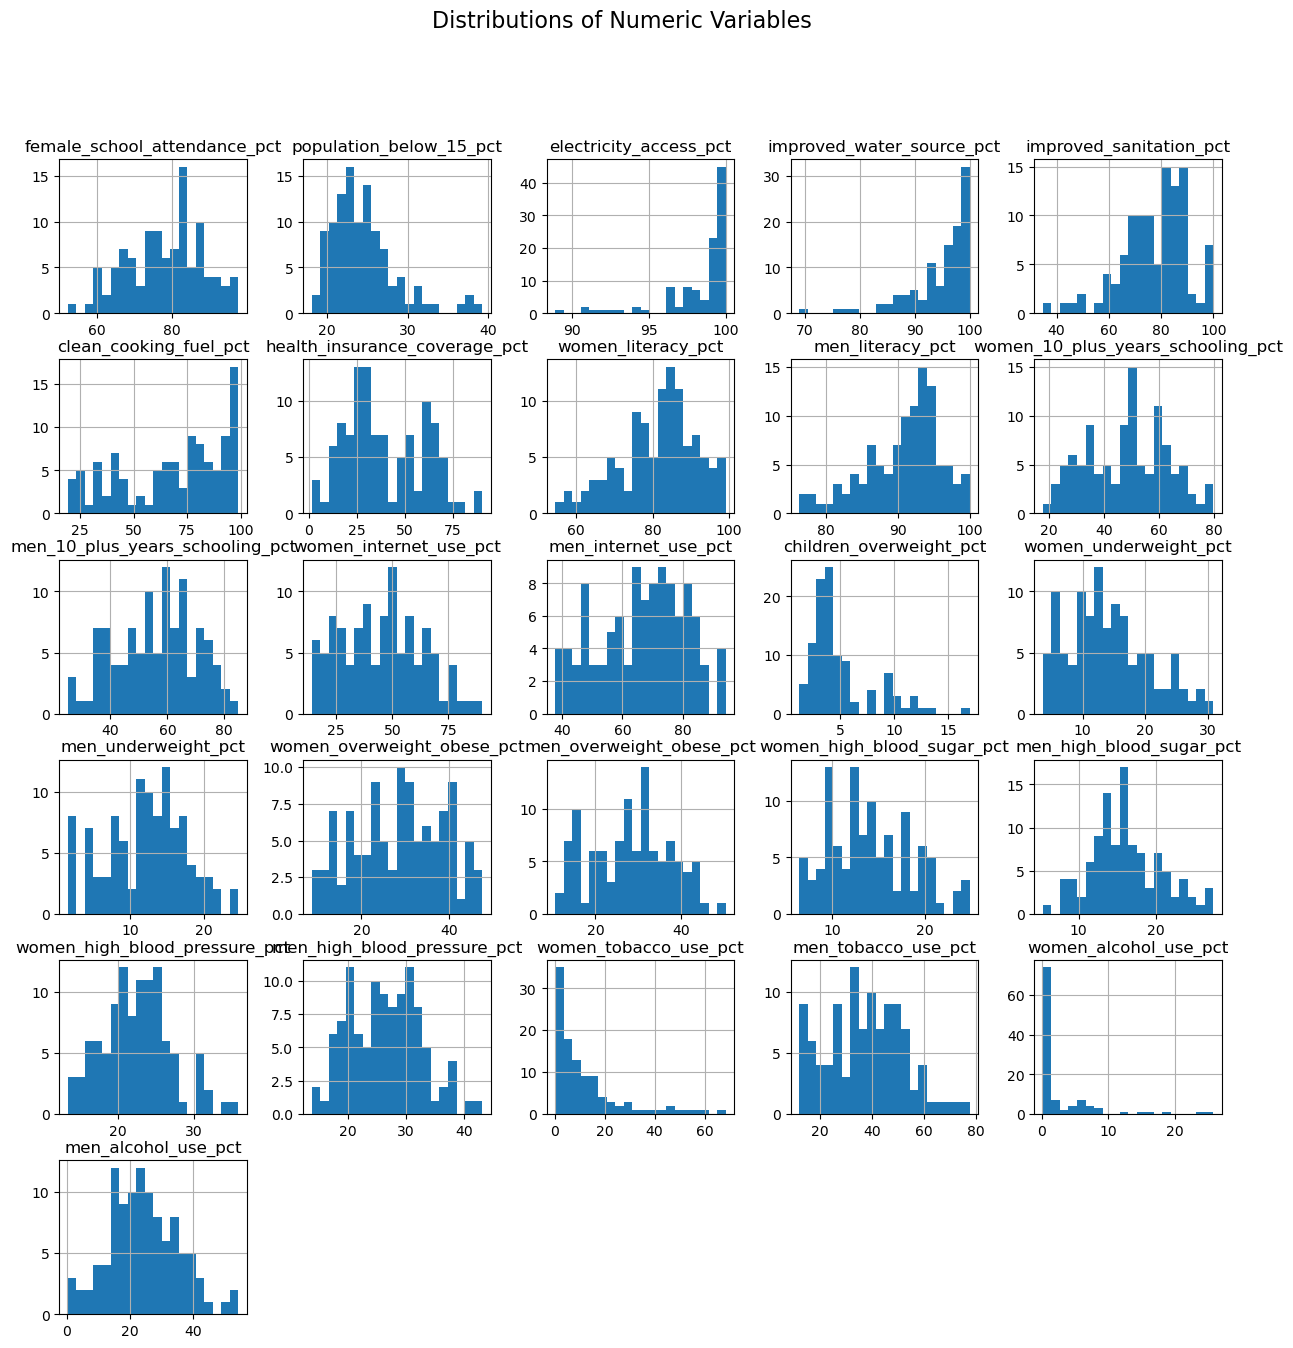

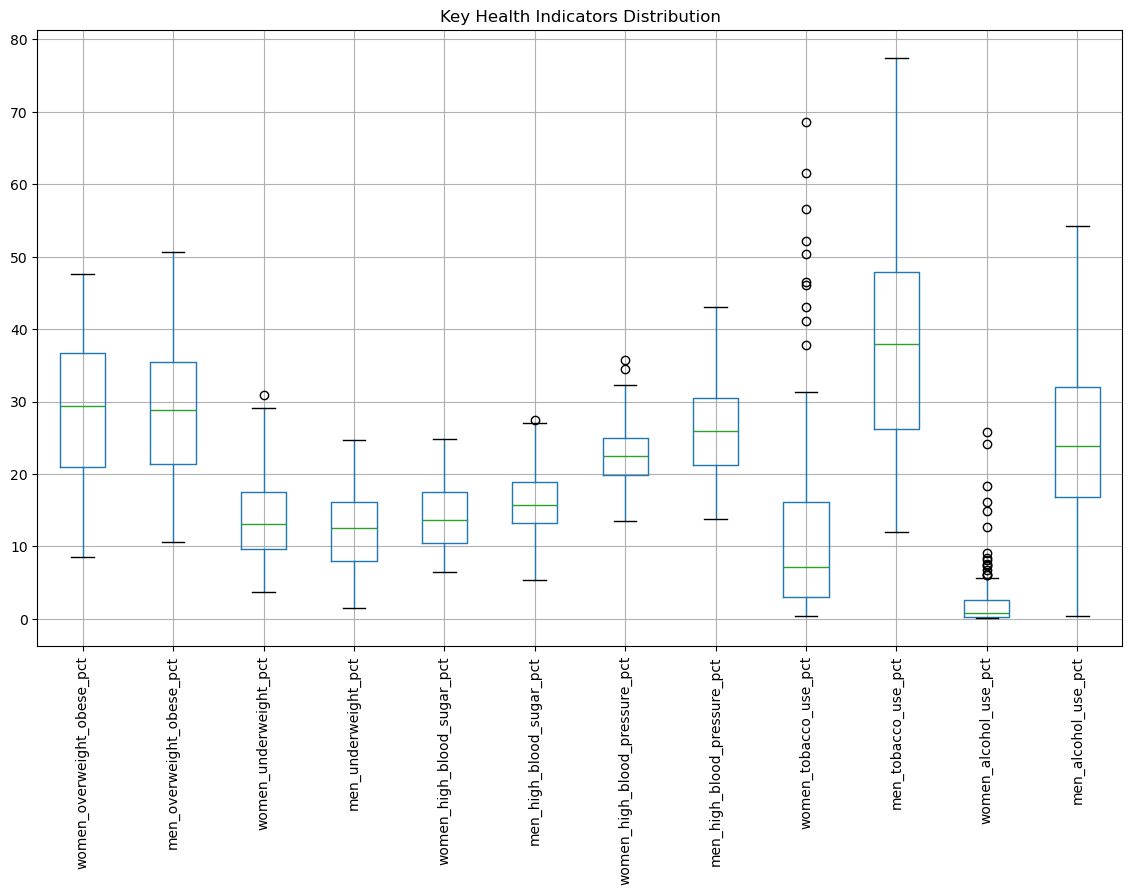

In [18]:
# -----------------------
# 3. Univariate Analysis
# -----------------------
numeric_cols = df.select_dtypes(include=['float64']).columns

# Histograms for numeric features
df[numeric_cols].hist(figsize=(15, 15), bins=20)
plt.suptitle("Distributions of Numeric Variables", fontsize=16)
plt.show()

# Boxplots for obesity, tobacco, alcohol, NCD risks
focus_cols = [
    "women_overweight_obese_pct", "men_overweight_obese_pct",
    "women_underweight_pct", "men_underweight_pct",
    "women_high_blood_sugar_pct", "men_high_blood_sugar_pct",
    "women_high_blood_pressure_pct", "men_high_blood_pressure_pct",
    "women_tobacco_use_pct", "men_tobacco_use_pct",
    "women_alcohol_use_pct", "men_alcohol_use_pct"
]

plt.figure(figsize=(14, 8))
df[focus_cols].boxplot(rot=90)
plt.title("Key Health Indicators Distribution")
plt.show()


/var/folders/4x/k2qry6p96n7fx3kjzqz4s0rm0000gn/T/ipykernel_27319/168679188.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="area", y="women_overweight_obese_pct", data=df, ci=None)


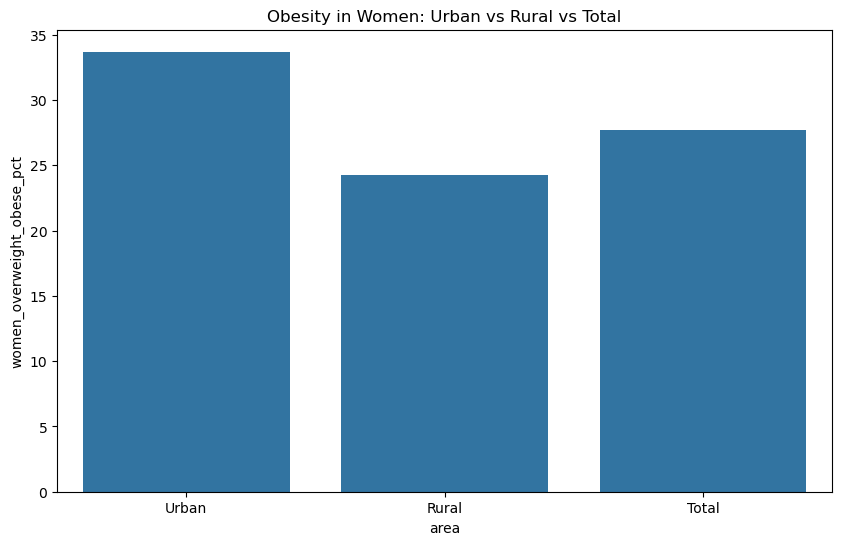

/var/folders/4x/k2qry6p96n7fx3kjzqz4s0rm0000gn/T/ipykernel_27319/168679188.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="area", y="men_overweight_obese_pct", data=df, ci=None)


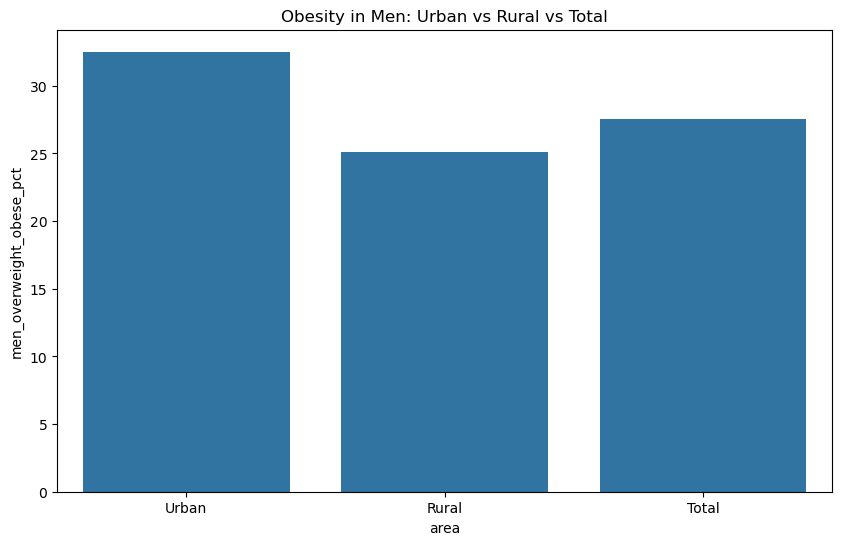

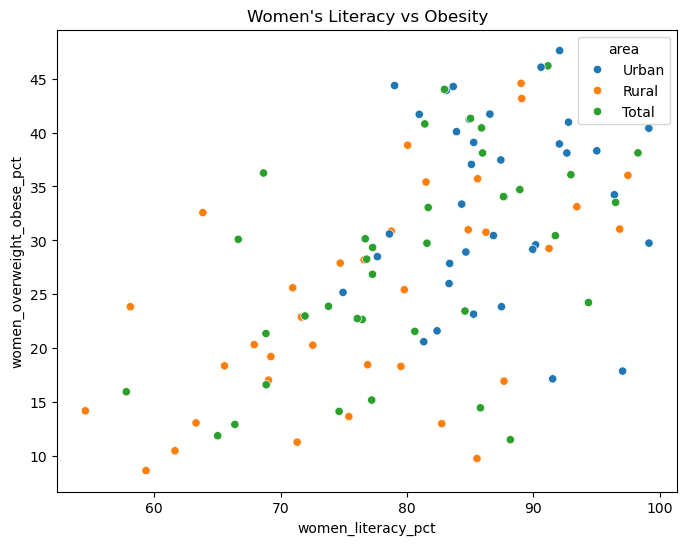

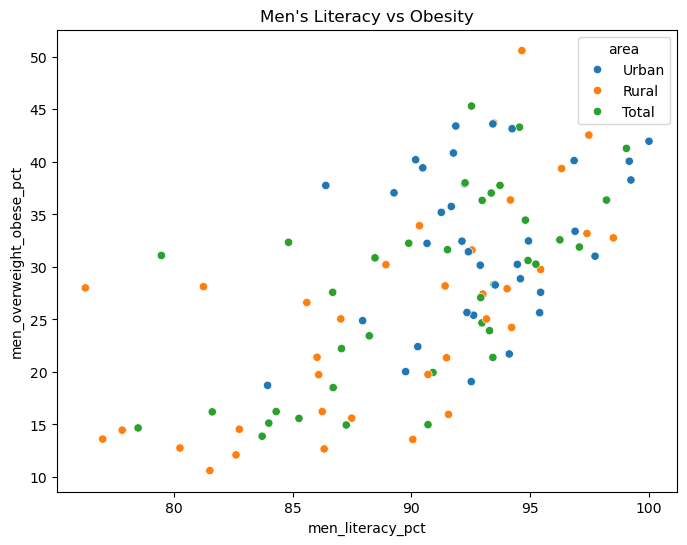

In [19]:
# -----------------------
# 4. Bivariate Analysis
# -----------------------
# Urban vs Rural vs Total obesity
plt.figure(figsize=(10,6))
sns.barplot(x="area", y="women_overweight_obese_pct", data=df, ci=None)
plt.title("Obesity in Women: Urban vs Rural vs Total")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x="area", y="men_overweight_obese_pct", data=df, ci=None)
plt.title("Obesity in Men: Urban vs Rural vs Total")
plt.show()

# Literacy vs Obesity correlation
plt.figure(figsize=(8,6))
sns.scatterplot(x="women_literacy_pct", y="women_overweight_obese_pct", hue="area", data=df)
plt.title("Women's Literacy vs Obesity")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x="men_literacy_pct", y="men_overweight_obese_pct", hue="area", data=df)
plt.title("Men's Literacy vs Obesity")
plt.show()

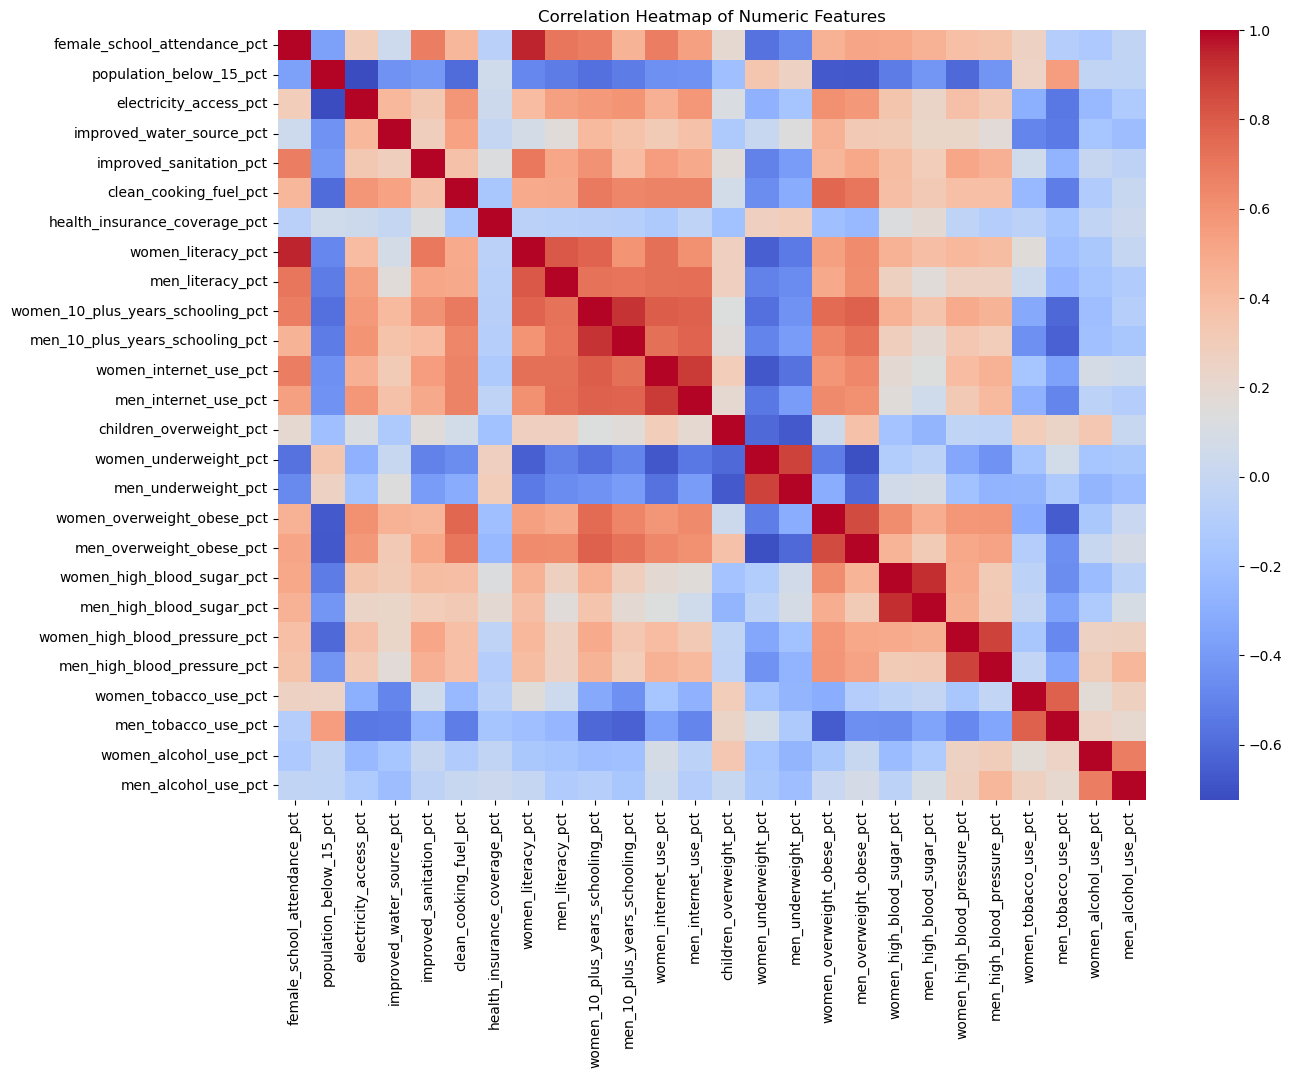

In [20]:
# -----------------------
# 5. Correlation Heatmap
# -----------------------
plt.figure(figsize=(14,10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [21]:
# -----------------------
# 6. State-level Top/Bottom Insights
# -----------------------
def top_bottom(col, n=5):
    print(f"\nTop {n} States in {col}:")
    print(df.groupby("state")[col].mean().sort_values(ascending=False).head(n))
    print(f"\nBottom {n} States in {col}:")
    print(df.groupby("state")[col].mean().sort_values().head(n))

# Example: Obesity & Tobacco
top_bottom("women_overweight_obese_pct")
top_bottom("men_overweight_obese_pct")
top_bottom("men_tobacco_use_pct")
top_bottom("women_tobacco_use_pct")




Top 5 States in women_overweight_obese_pct:
state
Puducherry      45.663333
Chandigarh      43.965000
NCT of Delhi    42.380000
Punjab          41.306667
Tamil Nadu      40.643333
Name: women_overweight_obese_pct, dtype: float64

Bottom 5 States in women_overweight_obese_pct:
state
Meghalaya       13.020000
Jharkhand       14.016667
Rajasthan       14.643333
Nagaland        14.846667
Chhattisgarh    16.166667
Name: women_overweight_obese_pct, dtype: float64

Top 5 States in men_overweight_obese_pct:
state
Andaman & Nicobar Islands    44.306667
Puducherry                   43.143333
Lakshadweep                  40.856667
NCT of Delhi                 39.856667
Ladakh                       39.170000
Name: men_overweight_obese_pct, dtype: float64

Bottom 5 States in men_overweight_obese_pct:
state
Bihar           15.656667
Rajasthan       15.866667
Jharkhand       16.523333
Chhattisgarh    16.666667
West Bengal     16.886667
Name: men_overweight_obese_pct, dtype: float64

Top 5 States in 

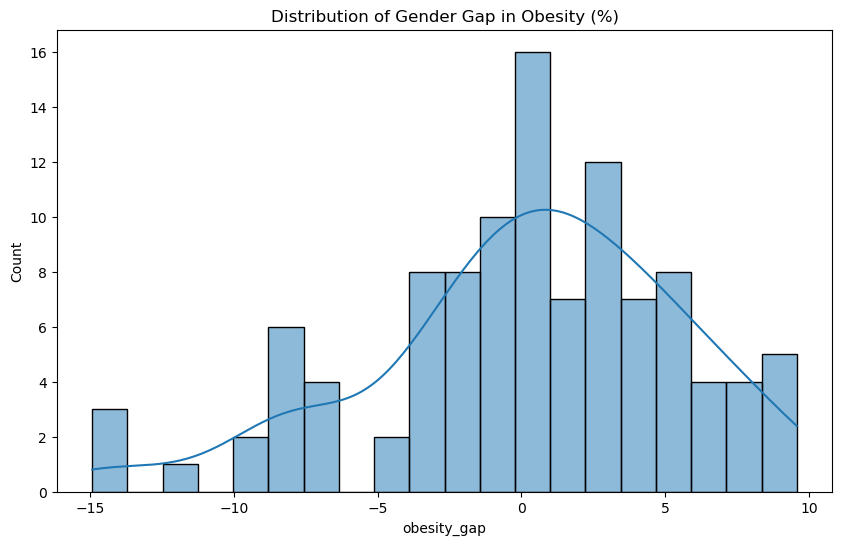

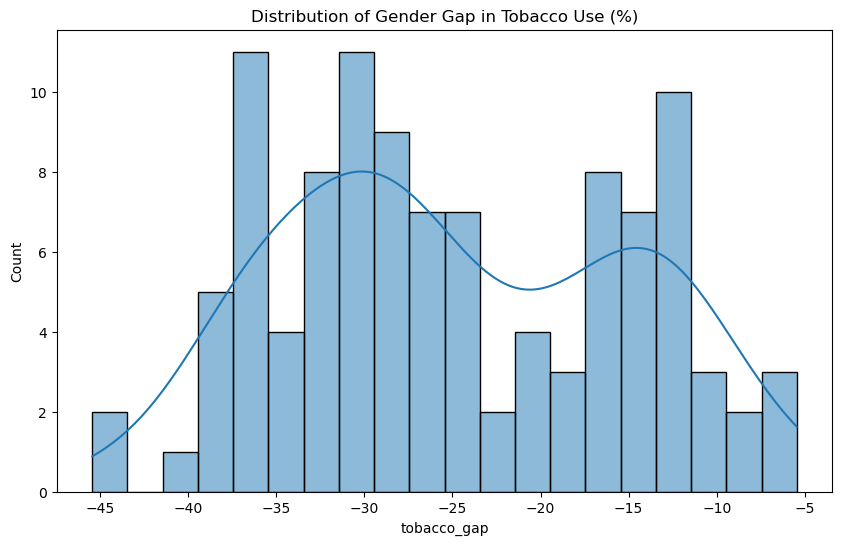

In [22]:
# -----------------------
# 7. Gender Gaps
# -----------------------
df["obesity_gap"] = df["women_overweight_obese_pct"] - df["men_overweight_obese_pct"]
df["tobacco_gap"] = df["women_tobacco_use_pct"] - df["men_tobacco_use_pct"]

plt.figure(figsize=(10,6))
sns.histplot(df["obesity_gap"], bins=20, kde=True)
plt.title("Distribution of Gender Gap in Obesity (%)")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df["tobacco_gap"], bins=20, kde=True)
plt.title("Distribution of Gender Gap in Tobacco Use (%)")
plt.show()